**Title: Rental Price Prediction of Airbnb In New York City**



**Authors:**\
Jiyang Ge (jg6064) ;
Ziyue Dong (zd 780) ;
Xintong Li (xl3269) ;\
*Xintong is responsible for uploading submissions

**Abstract :** This project focuses on predicting prices for airbnb in NYC. We consider it as a supervised regression problem.We approached it using Linear and Ridge Regression, Random Forest, Linear SVR and KNN. Despite all the advantages and disadvantages of each approach, the results showed that Random Forest had the best performance for this problem. For inspiration of future predicting models, ensemble methods and deep learning may improve our model more.





 **1. Introduction and Motivation:**


Airbnb is a platform where millions of hosts and travelers list their space and book unique accommodations anywhere in the world. Airbnb affects the city's housing supply and affordability. In a modern, busy cosmopolitan like NYC, there are so many competitions for housing and huge demands for accommodations, Airbnb pricing is important to get right. If the price is too high the hosts might risk losing customers while if the price is too low they might be missing out on potential benefits. The goal of our project is to come up with the appropriate prediction of Airbnb price using machine learning, so the hosts can achieve optimal profits. One of the challenges we faced is that since the raw data we used consists of both categorical and numerical values and missing values which makes classification difficult



**2. Description of Dataset**

The data was downloaded from the Inside Airbnb Dataset ‘New York City Airbnb Open Data’ (link: http://insideairbnb.com/new-york-city/). Inside Airbnb is an independent, non-commercial organization that provides Airbnb data in cities around the world. Specifically, this dataset describes the listing activity and metrics in NYC, NY  in  2019. The columns include the following information: id number of the housing, name of the host, id number of the host, the neighbourhood group that the housing is located (Queens, Brookly, Manhattan,Bronx and Staten Island), the specific neighbourhood, latitude and longitude, type of room, price per night, the minimum nights allowed to book, the number of reviews, the date of last review, average reviews per month, the number of host listings, and the available days in 365 days.


In [0]:
from google.colab import drive
import os 
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
df=pd.read_csv('AB_NYC_2019.csv')

2.1 Data Exploration


Intuitively, prices should be largely reflected by geographic information, so we take a deeper look at the neighbourhood_group presented 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island', and 'Bronx' first


In [0]:
nei_list=['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx']
price_list_by_n=[]

for i in range(len(nei_list)):
  sub=df.loc[df['neighbourhood_group'] == nei_list[i]]
  price_list_by_n.append(sub[['price']])
  
#Create a dataframe with all the descriptive data of each neighbourhood
p_l_b_n_2=[]

for x in price_list_by_n:
    i=x.describe(include='all')
    i=i.iloc[1:]
    i.reset_index(inplace=True)
    i.rename(columns={'index':'Stats'}, inplace=True)
    p_l_b_n_2.append(i)
  
for i in range(4): p_l_b_n_2[i].rename(columns={'price':nei_list[i]}, inplace=True)
  
stat_df=p_l_b_n_2
stat_df=[df.set_index('Stats') for df in stat_df]
stat_df=stat_df[0].join(stat_df[1:])
stat_df

,Brooklyn,Manhattan,Queens,Staten Island,price
Stats,,,,,
mean,124.383207,196.875814,99.517649,114.812332,87.496792
std,186.873538,291.383183,167.102155,277.620403,106.709349
min,0.000000,0.000000,10.000000,13.000000,0.000000
25%,60.000000,95.000000,50.000000,50.000000,45.000000
50%,90.000000,150.000000,75.000000,75.000000,65.000000
75%,150.000000,220.000000,110.000000,110.000000,99.000000
max,10000.000000,10000.000000,10000.000000,5000.000000,2500.000000


From the dataframe above we can see that as expected, manhattan has the highest price on average, while bronx and queens are on the lower end. The standard deviations are quite large for every borough and this might be a result of the big differences between the extreme values. We plot the prices per borough for a clearer view below:


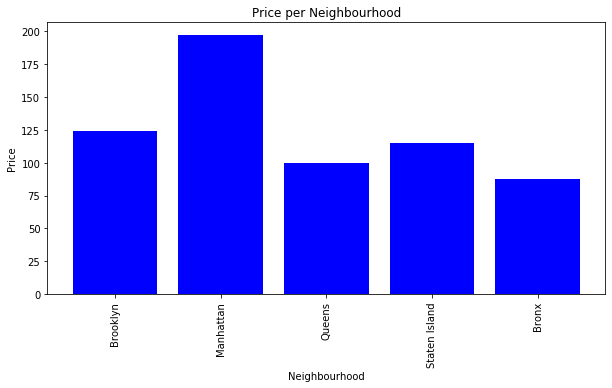

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
x=np.arange(5)
plt.figure(figsize = (10,5))
plt.bar(x, stat_df.iloc[0], color = 'b')
plt.xticks(x, nei_list, rotation = 'vertical')
plt.xlabel('Neighbourhood')
plt.ylabel('Price')
plt.title('Price per Neighbourhood')
plt.show()

We use the longitude and latitude to plot the price onto a NYC map:

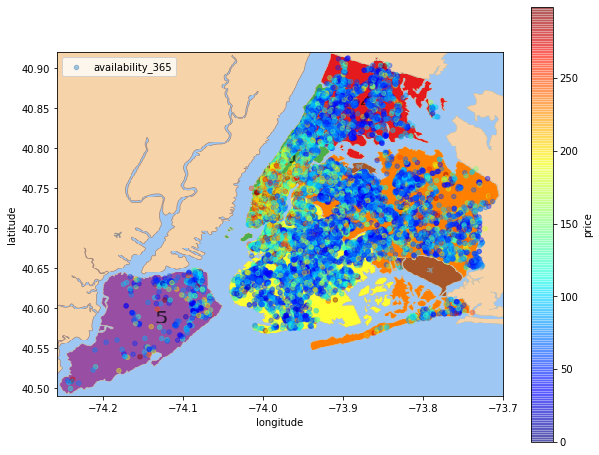

In [0]:
# Exclude the extreme points
df1=df[df.price<300]

import urllib
i=urllib.request.urlopen('https://upload.wikimedia.org/wikipedia/commons/thumb/3/34/5_Boroughs_Labels_New_York_City_Map.svg/450px-5_Boroughs_Labels_New_York_City_Map.svg.png')
nyc_img=plt.imread(i)
plt.figure(figsize=(10,8))
plt.imshow(nyc_img,zorder=0,extent=[-74.258, -73.7, 40.49,40.92])

ax=plt.gca()
df1.plot(kind='scatter', x='longitude', y='latitude', label='availability_365', c='price', ax=ax, 
           cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, zorder=5)

plt.show()

We can see from the graph above that the more expensive airbnbs are distributed in Manhattan area with larger density. This is an implication that if an airbnb is located in this area, we would predict the price to be relatively higher.

2.2 Data Cleaning

The dataset we use to tangle this problem includes features such as geographical information, room type, number of reviews. However, there are some problems that may lead to difficultes to the model deployment: the raw data consists of both categorical and numerical values, which is bad for classification models; also, few features contains missing values. Before applying any model or algorithm, we clean the data with Pandas as the following:
 - Convert the variable "room_type" to binary: “Entire home/apt” to 1 and others to 0
 - Fill Missing values of  variable “review_per_month” to 0
 - Create dummy variables for the categorical variable ‘neighbourhood’
 - Normalize all the features so that each feature has 0 mean and 1 standard deviation





In [0]:
#Convert the type of variable 'room_type'
df['entrie_home']=df['room_type'].apply(lambda x: 1 if x=='Entire home/apt' else 0)
#Fill missing values of variable "review_per_month"
df[['reviews_per_month']]=df[['reviews_per_month']].fillna(0)
#create dummy variables according to variable "neighbourhood_group"
neig = pd.get_dummies(df['neighbourhood_group'],drop_first=False)

After cleaning, we pick the variables we want to use as features to predict the target variable: 'latitude', 'longitude', 'entrie_home', 'minimum_nights',  'number_of_reviews', 'reviews_per_month','calculated_host_listings_count' and 'availability_365'. \
Then we use model_selection of sklearn to randomly split our data, as 80% to taining data and 20% to test data.

In [0]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

X_ess=df[['latitude', 'longitude','entrie_home','minimum_nights','number_of_reviews','reviews_per_month',
       'calculated_host_listings_count', 'availability_365']]
train = pd.concat([X_ess,neig],axis=1)
scaled_train=pd.DataFrame(preprocessing.scale(train),columns=train.columns)
X_train, X_test, Y_train, Y_test = train_test_split(scaled_train, df['price'], test_size=.2)

In [0]:
print('The amount of training data: ',len(X_train))
print('The amount of test data: ',len(X_test))

The amount of training data:  39116
The amount of test data:  9779


An instance of sample looks like:

In [0]:
print(X_train.head(1))
print(Y_train.head(1))

       latitude  longitude  entrie_home  ...  Manhattan    Queens  Staten Island
28317  -0.67356   -0.42032     0.961415  ...  -0.891833 -0.362035      -0.087677

[1 rows x 13 columns]
28317    300
Name: price, dtype: int64


**3. Methodology**

3.1 Models


3.1.1 Linear Regression and Ridge Linear Regression

Since our target variable, the rental price, is a continuous variable, we consider this problem as a supervised regression problem instead of classification. Thus, the baseline model is the default linear regression. 

In [0]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train,Y_train)
pred_lr= reg.predict(X_test)

However, a clearly linear regression is always too oversimplified for reality problem because it assumes the covariates and response variables to have linear relationship which may not suit our problem. To improve this, we also use another linear model , the Ridge Regression Model with sklearn.linear_model.Ridge. This solves a regression model where the loss function is the linear least squares function and regularization is given by the l2-norm. To find the optimal parameters and avoid overfitting, we also compare the performance of model with alphas=[0.001,0.01,0.1,1] as well as cross validation by RidgeCV.

In [0]:
from sklearn.linear_model import RidgeCV

# To avoid overfit we use cross validation
ridge_cv = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train,Y_train)
pred_ridge=ridge_cv.predict(X_test)

3.1.2 Random Forest

Random forest is also a common ensemble learning method for regression. It runs decision trees in parallel which means there is no interaction between these trees while building the trees.
Different kinds of models have different advantages. The random forest model is very good at handling tabular data with numerical features, or categorical features with fewer than hundreds of categories. Unlike linear models, random forests are able to capture non-linear interaction between the features and the target. Since the linear model above did not perform well, we guess there should be a nonlinear relationship between target variable and features which means nonlinear model like random forest may predict well.One important note is that because the result of decision trees will vary a lot as the parameters change a little, it is important to try different combinations of parameters in order to find the best fitted model.


In [0]:
from sklearn.ensemble import RandomForestRegressor
# random forest regressor
def random_forest_model(x_train, y_train, x_test, y_test):
    best_test_score = 0 
    best_train_score = 0
    best_depth = 0
    # tune for tree depth from 1 to 20
    for j in range(1, 21):
        rf = RandomForestRegressor(n_estimators=50, max_depth=j, oob_score=True)
        rf.fit(x_train, y_train)
        score_train = rf.score(x_train, y_train)
        score = rf.score(x_test, y_test)
        if score > best_test_score:
            best_test_score = score
            best_train_score = score_train
            best_depth = j
    return best_train_score, best_test_score, best_depth

Because the result of decision trees will vary a lot as the parameters change a little, it is important to try different combinations of parameters in order to find the best fitted model.

In [0]:
rf_values = random_forest_model(X_train, Y_train, X_test, Y_test)
print ('Train Score with Best Test:', rf_values[0])
print ('Best Test Score:', rf_values[1])
print ('Best Depth', rf_values[2])
rf = RandomForestRegressor(n_estimators=50, max_depth=rf_values[2], oob_score=True)
rf.fit(X_train, Y_train)
pred_rf= rf.predict(X_test)


Train Score with Best Test: 0.408632400176301
Best Test Score: 0.16188107443912336
Best Depth 7


3.1.3 Linear SVR


Another common approach is Support Vector Regression. The SVR uses the same principles as the SVM for classification: to minimize error, individualizing the hyperplane that maximizes the margin. However, the implementation of sklearn.SVR is based on libsvm. The fit time complexity is more than quadratic with the number of samples, which makes it hard to scale to datasets with more than a couple of 10000 samples. So instead, we use skearn.LinearSVR. It is similar to SVR with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples. The non-linear SVR model may give a better result, but in this project, we only model the linear SVR considering computational efficiency.

In [0]:
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(LinearSVR(max_iter=1000),{'C':[0.01,0.1,1,10]}, cv=5,n_jobs=-1)
grid_search.fit(X_train,Y_train)
grid_search.best_params_

{'C': 10}

We use  GridSearchCV to do model tuning to find the optimal C value that gives best prediction and cross validation with fold 5 to avoid overfitting. 

In [0]:
regr = LinearSVR(C=10)
regr.fit(X_train,Y_train)
pred_regr=regr.predict(X_test)

3.1.4 KNN

The last way to approach is by the k-nearest neighbors algorithm. It is a form of memory based learning wherein we don’t learn a function of features to estimate the target variable. It searches the training data for the k nearest neighbors, as calculated by Euclidean distance function, then does the regression process based on the value of these k neighbors. To find the optimal value of k, we compared the performance of knn models with k in the range of (5,25).


In [0]:
#Multi-Variate KNN Model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

#Method to find the optimal amount of neighbors
def findoptK(k_list):
    opt_k=0
    opt_rmse=100000
    for k in k_list:
        knn= KNeighborsRegressor(n_neighbors=k,algorithm='brute')
        knn.fit(X_train, Y_train)
        knn_pred = knn.predict(X_test)
        if mean_squared_error(Y_test, knn_pred)**(1/2)< opt_rmse:
            opt_rmse=mean_squared_error(Y_test, knn_pred)**(1/2)
            opt_k=k
    return opt_k

In [0]:
k_list=range(5,25)
knn= KNeighborsRegressor(n_neighbors=findoptK(k_list),algorithm='brute')
knn.fit(X_train, Y_train)
pred_knn = knn.predict(X_test)

3.2 Evaluation metrics

To evaluate regression models, R-squared is the most commonly used. It is a statistical measure of how close the data are to the fitted regression line. It is also known as the coefficient of determination, or the coefficient of multiple determination for multiple regression.
R-squared is the percentage of the response variable variation that is explained by a linear model as R-squared = Explained variation / Total variation. 0% indicates that the model explains none of the variability of the response data around its mean. While 100% indicates that the model explains all the variability of the response data around its mean. In general, the higher the R-squared, the better the model fits your data. However, there are important conditions for this guideline that I’ll talk about both in this post and my next post.

We also used Root Mean Square Error(RMSE) and Median Absolute Error(MAE) to evaluate the models. RMSE is simply the root of mean squred error. We used Median Absolute Error becuase it is less sensitive to outliers than Mean Squared Error and translates nicely to a dollar amount that is relative to price.

In [0]:
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

#A dictionary to store evaluation data
Eva_data={'RMSE':[], 'MAE':[], 'R2_testing':[]}

3.3 Code for formulate evaluation for each model 

In [0]:
pred_list=[pred_lr,pred_ridge,pred_rf,pred_regr,pred_knn]

for pred in pred_list:
  Eva_data['RMSE'].append(mean_squared_error(Y_test, pred)**(1/2))
  Eva_data['MAE'].append(median_absolute_error(Y_test, pred))
  Eva_data['R2_testing'].append(r2_score(Y_test,pred))

In [0]:
eva_df=pd.DataFrame(Eva_data,index=['Linear Regression','Ridge Regression','Random Forest','Linear SVR','KNN'])
eva_df

,RMSE,MAE,R2_testing
Linear Regression,233.579178,46.508230,0.094903
Ridge Regression,233.579188,46.508723,0.094903
Random Forest,228.254708,33.221637,0.135696
Linear SVR,237.890616,28.451702,0.061182
KNN,230.745922,31.090909,0.116727


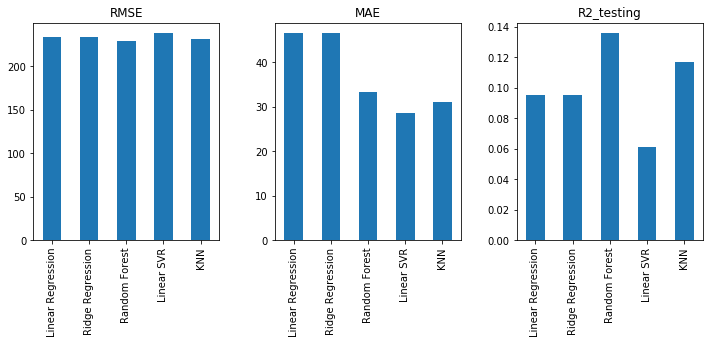

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (12,4))
plt.subplots_adjust(wspace=0.3)

for i in range(len(eva_df.columns)):
  eva=eva_df.columns[i]
  eva_df[eva].plot(kind='bar', ax=axes[i], title=eva)


**4. Results**



From the above histograms, we can see that after implementation, the test data accuracy of Linear Regression turns out to be really low, so clearly linear regression is too oversimplified for our problem. Also, the Ridge Regression perform similarly to Linear Regression with a little bit differences in RMSE and MAE which means it also does not improve the result a lot. 
Because we have a relatively large amount of data, the probability of over-fitting seem to be low. We also do the R2-score in training set and confirm that each R2-score is always between 40% and 70% which means these models do not have a too high R2 as not true.

We can see that Random Forest, Linear SVR and KNN models perform both have their advantages and weaknesses.  Random Forest has the lowest RMSE while Linear SVR has the lowest MAE. However, as the models’ RMSE and MAE do not vary a lot, we can use R2 score in testing dataset to determine which model perform better. As Random Forest model has the highest R2 score as 13.57%, we can conclude that it is the best-performance model. This is understandable since the reality relationship seem to be nonlinear. In general, our best model Random Forest explains 13.57% of the variation in the target variable around its mean for any given test dataset.

Overall, we see that ensemble methods are promising, but require a considerable amount of computational time as well to tune for the best parameters. With further and more comprehensive tuning, it is very likely that the Median Absolute Error could be decreased for an ensemble method.


**5. Discussion**

5.1 Strengths and Weaknesses of The Proposed Methodology


Linear regression is the simplest regression model that assuming a linear relationship between target variable and response variables. However, as the relationship in real dataset is high-possible of not being perfectly linear, this model would not fit the data well. Ridge Regression improves Linear Regression a little but still not as good as expected. 
Compared to Linear Regression, Linear SVR performs well no matter the data is linear or not. However,  it is more suitable for classification instead of regression.

Random forest model reduces the probability of overfitting by averaging the prediction results of a diverse set of trees. It is always compared with the decision tree -  the total bias of random forest is higher, as it trains independent trees on random samples of data. However, the final prediction result is the average of all individual trees, which alleviate the increased bias by reducing variance. Therefore, the accuracy of the random forest is always slightly higher than the decision tree.

KNN model is non-parametric, which means it does not make an assumption about the underlying data distribution pattern, and this reduces the bias due to the model selection compared to parametric methods. However, this model can be problematic since we have a group of  features. The high dimensionality data not only prolong the computation time, but also lower the accuracy of KNN. Also, this model is very sensitive to outliers.


5.2 Improvements and Limitations 

The results are fairly well because the price depends on various factors that are far more than the response variables we used, but it is not good-enough since the best model only explain 13.57% of the variance in given test dataset. There are some more can be added as response variables such as the number of rooms, number of bathrooms, number of subway lines in 300m, pet-friendly or not, etc. Also, as from some predictions, we conclude the regression to be linear, we can try more polynomial regression models that may fit the problem better and may get more accurate results.


**6. Conclusion**

6.1 Summary of the problem, findings and limitations.

This project using different models including Linear Regression, Ridge Regression, Linear SVR, Random Forest, and KNN to predict prices for airbnb in NYC. Through comparing RMSE, MAE, and R2-score in testing dataset, we conclude that Random Forest outperforms others. However, as R2 of 13.57%, our best model could not predict the price very precisely.

6.2 Future work directions:


*  Try out deep learning models such as neural networks to improve performance.
*  Use better quality data which includes review contents. And use models with natural language processing (NLP) to process reviews 
*  In addition to predicting base prices, a sequence model could be created to calculate daily rates using data on seasonality and occupancy.
*   Tailor the model more specifically to new listings in order to help hosts set prices for new housings, by removing features that would not be known at the time such as availability and number of reviews.





**Reference**

“Predicting Airbnb prices with machine learning and deep learning”Laura Lewis, May 22\
“Airbnb Pricing Predictions” https://airbnb-pricing-prediction.herokuapp.com/ \
Friedrichs, F., & Igel, C. (2005). Evolutionary tuning of multiple SVM parameters. Neurocomputing, 64, 107-117.\
Zhang, A. X., Noulas, A., Scellato, S., & Mascolo, C. (2013, September). Hoodsquare: Modeling and recommending neighborhoods in location-based social networks. In Social Computing (SocialCom), 2013 International Conference on (pp. 69-74). IEEE. http://arxiv.org/pdf/1308.3657.pdf\
Tang, E., & Sangani, K. (n.d.). Neighborhood and price prediction for San Francisco Airbnb Listings\
Kalehbasti, Pouya Rezazadeh,Nikolenko, Liubov & Rezaei Hoormazd. Airbnb Price Prediction Using Machine Learning and Sentiment Analysis (2019) 1907.12665.arXiv.cs.LG
